In [1]:
import os,sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io
import numpy.fft as fft
from ipywidgets import interact,interactive,fixed,interact_manual
import ipywidgets as widgets
import cv2

#Progress bar function
def update_progress(progress):
    barLength = 100 # Modify this to change the length of the progress bar
    status = ""
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
        status = "error: progress var must be float\r\n"
    if progress < 0:
        progress = 0
        status = "Halt...\r\n"
    if progress >= 1:
        progress = 1
        status = "Done...\r\n"
    block = int(round(barLength*progress))
    text = "\rPercent: [{0}] {1}% {2}".format( "#"*block + "-"*(barLength-block), progress*100, status)
    sys.stdout.write(text)
    sys.stdout.flush()

In [2]:
if sys.platform=='win32':
    data_directory='Z:\TSLO_Experiment\VoluntaryMicrosaccade\Experiment2ObliqueMicrosaccadeWNeutral\S01\LatencyTask'
elif sys.platform=='linux':
    data_directory='/home/coateslab/LabData/TSLOTestVideos/PilotTest/CrowdingStream/Fullblock/Videos/'
filedir_list=[]
for root,dirs,file in os.walk(data_directory):
    if "LatencyTask" in root:
        filedir_list.append(root)
    
# Eye pos Compilation
failedFiles=[]
filteredeyepos=[]
# create_dataframe=True
# while create_dataframe==True:
counter=0
num_elements=len(filedir_list)
for foldername in filedir_list:
    update_progress(counter/num_elements)
#     print(counter)
    counter+=1
    filelist=os.listdir(foldername)
    subj_id=foldername[foldername.find("S0"):(foldername.find("S0")+3)]
    for filename in filelist:
        if 'Filtered' in filename:
            # First we load the mat file into jupyter
            mat=scipy.io.loadmat(os.path.join(foldername,filename))
            # we then obtain only the fields that are needed (like the one with eye movement and timestamps)
            eyepos=pd.DataFrame(mat['eyeposFiltered'])
#             folderdate=foldername.replace('/mnt/hd/ao/rotVids/','')
            # we name the first two columns as x and y positions and the third as time
            eyepos=eyepos.rename(columns={0:'xpos',1:'ypos',2:'time'})
            # We finally add file details to the data structure which can later be used to 
            # query into the dataframe
            eyepos['filename']=filename
            eyepos['code']=filename[0:filename.find('_Video')]
            eyepos['subj_id']=subj_id
            #The temporary data is then appended to the bigger data structure 
            filteredeyepos.append(eyepos)
            
filteredeyepos=pd.concat(filteredeyepos)

# Saccade data compilation
# % time
# This cell compiles the saccade metrics obtained from the ReVAS eye position filters and saccade(and drift) detection functions
# In this case we obtain the saccade and drift metrics from the mat files that are created by ReVAS
failedMicroSacc=[]
microSaccData=[]
driftData=[]
create_pickle= False
# while create_dataframe==True:
num_elements=len(filedir_list)
counter=0
for foldername in filedir_list:
    update_progress(counter/num_elements)
    counter+=1
    failedMicroSacc=os.listdir(foldername)
    filelist=os.listdir(foldername)
    subj_id=foldername[foldername.find("S0"):(foldername.find("S0")+3)]
    for filename in filelist:
        if 'sacsdrifts' in filename:
#             try:
            # First we load the mat file into jupyter
            mat=scipy.io.loadmat(os.path.join(foldername,filename))
            # we get the foldername from the filepath
#             folderdate=foldername.replace('/mnt/hd/ao/vids/','')
            # initially we create empty pandas dataframes
            tempSaccData=pd.DataFrame({'Duration':[],'onsetIdx':[],'offsetIdx':[],'onsetTime':[],'offsetTime':[],'xAmp':[],'yAmp':[]\
                                       ,'VectorAmp':[],'Direction':[],'peakVel':[],'meanVel':[]})
            # 1. form saccade dataset for the file
            if mat['params']['saccades'][0,0]==0 or len((mat['params']['saccades'][0,0]))==0 or (mat['params']['saccades'][0,0].size)==0:
                tempSaccData=tempSaccData.append({'Duration':np.nan,'onsetIdx':np.nan,'offsetIdx':np.nan,'onsetTime':np.nan,\
                                                  'offsetTime':np.nan,'xAmp':np.nan,'yAmp':np.nan,\
                                                  'VectorAmp':np.nan,'Direction':np.nan,'peakVel':np.nan,'meanVel':np.nan},ignore_index=True)
            else:
                # we determine the size of the saccade array
                tempSaccData=pd.DataFrame({'Duration':[],'onsetIdx':[],'offsetIdx':[],'onsetTime':[],'offsetTime':[],'xAmp':[],'yAmp':[]\
                                       ,'VectorAmp':[],'Direction':[],'peakVel':[],'meanVel':[]})

                saccArraySize=mat['params']['saccades'][0,0]['duration'].size # for now use one of the fields of the struct array
                durationList=[]
                onsetIdxList=[]
                offsetIdxList=[]
                onsetTimeList=[]
                offsetTimeList=[]
                xAmpList=[]
                yAmpList=[]
                VectorAmpList=[]
                DirectionList=[]
                peakVelList=[]
                maxVelList=[]
                for itemIdx in range(saccArraySize): #here we would want to unapack each item from the struct and append it to a list 
                    duration=(mat['params']['saccades'][0,0]['duration'][itemIdx].flatten().item().item())
                    onsetIdx=(mat['params']['saccades'][0,0]['onsetIndex'][itemIdx].flatten().item().item())
                    offsetIdx=(mat['params']['saccades'][0,0]['offsetIndex'][itemIdx].flatten().item().item())
                    onsetTime=((mat['params']['saccades'][0,0]['onsetTime'][itemIdx].flatten().item().item()))
                    offsetTime=(mat['params']['saccades'][0,0]['offsetTime'][itemIdx].flatten().item().item())
                    xAmp=(mat['params']['saccades'][0,0]['xAmplitude'][itemIdx].flatten().item().item())
                    yAmp=(mat['params']['saccades'][0,0]['yAmplitude'][itemIdx].flatten().item().item())
                    VectorAmp=(mat['params']['saccades'][0,0]['vectorAmplitude'][itemIdx].flatten().item().item())
                    Direction=(mat['params']['saccades'][0,0]['direction'][itemIdx].flatten().item().item())
                    peakVel=(mat['params']['saccades'][0,0]['peakVelocity'][itemIdx].flatten().item().item())
                    maxVel=(mat['params']['saccades'][0,0]['meanVelocity'][itemIdx].flatten().item().item())

                    tempSaccData=tempSaccData.append({'Duration':duration,'onsetIdx':onsetIdx,'offsetIdx':offsetIdx,'onsetTime':onsetTime,\
                              'offsetTime':offsetTime,'xAmp':xAmp,'yAmp':yAmp,'VectorAmp':VectorAmp,'Direction':Direction\
                              ,'peakVel':peakVel,'meanVel':maxVel},ignore_index=True)
            # We finally add file details to the data structure which can later be used to 
            # query into the dataframe
            tempSaccData['filename']=filename
            tempSaccData['code']=filename[0:filename.find('_Video')]
            tempSaccData['subj_id']=subj_id
            #The temporary data is then appended to the bigger data structure 
            microSaccData.append(tempSaccData)
#             except:
#                 failedMicroSacc.append(os.path.join(foldername,filename))
# create_dataframe=True
microSaccData=pd.concat(microSaccData)
# we then remove the saccade data with NaNs
microSaccFiltered=microSaccData[microSaccData['Direction'].notnull()]

# Drift data compilation
# % time
# This cell compiles the saccade metrics obtained from the ReVAS eye position filters and saccade(and drift) detection functions
# In this case we obtain the saccade and drift metrics from the mat files that are created by ReVAS
failedDrifts=[]
driftData=[]
create_pickle= False
# while create_dataframe==True:
num_elements=len(filedir_list)
counter=0
for foldername in filedir_list:
    update_progress(counter/num_elements)
    counter+=1
    failedMicroSacc=os.listdir(foldername)
    filelist=os.listdir(foldername)
    subj_id=foldername[foldername.find("S0"):(foldername.find("S0")+3)]
    for filename in filelist:
        if 'sacsdrifts' in filename:
#             try:
            # First we load the mat file into jupyter
            mat=scipy.io.loadmat(os.path.join(foldername,filename))
            # we get the foldername from the filepath
#             folderdate=foldername.replace('/mnt/hd/ao/rotVids/','')
            # initially we create empty pandas dataframes
            tempDriftData=pd.DataFrame({'Duration':[],'onsetIdx':[],'offsetIdx':[],'onsetTime':[],'offsetTime':[],'xAmp':[],'yAmp':[]\
                                       ,'VectorAmp':[],'Direction':[],'peakVel':[],'meanVel':[]})
            # 1. form saccade dataset for the file
            if mat['params']['drifts'][0,0]==0 or len((mat['params']['drifts'][0,0]))==0 or (mat['params']['drifts'][0,0].size)==0:
                tempDriftData=tempSaccData.append({'Duration':np.nan,'onsetIdx':np.nan,'offsetIdx':np.nan,'onsetTime':np.nan,\
                                                  'offsetTime':np.nan,'xAmp':np.nan,'yAmp':np.nan,\
                                                  'VectorAmp':np.nan,'Direction':np.nan,'peakVel':np.nan,'meanVel':np.nan},ignore_index=True)
            else:
                # we determine the size of the saccade array
                tempSaccData=pd.DataFrame({'Duration':[],'onsetIdx':[],'offsetIdx':[],'onsetTime':[],'offsetTime':[],'xAmp':[],'yAmp':[]\
                                       ,'VectorAmp':[],'Direction':[],'peakVel':[],'meanVel':[]})

                driftArraySize=mat['params']['drifts'][0,0]['duration'].size # for now use one of the fields of the struct array
                durationList=[]
                onsetIdxList=[]
                offsetIdxList=[]
                onsetTimeList=[]
                offsetTimeList=[]
                xAmpList=[]
                yAmpList=[]
                VectorAmpList=[]
                DirectionList=[]
                peakVelList=[]
                maxVelList=[]
                for itemIdx in range(driftArraySize): #here we would want to unapack each item from the struct and append it to a list 
                    duration=(mat['params']['drifts'][0,0]['duration'][itemIdx].flatten().item().item())
                    onsetIdx=(mat['params']['drifts'][0,0]['onsetIndex'][itemIdx].flatten().item().item())
                    offsetIdx=(mat['params']['drifts'][0,0]['offsetIndex'][itemIdx].flatten().item().item())
                    onsetTime=((mat['params']['drifts'][0,0]['onsetTime'][itemIdx].flatten().item().item()))
                    offsetTime=(mat['params']['drifts'][0,0]['offsetTime'][itemIdx].flatten().item().item())
                    xAmp=(mat['params']['drifts'][0,0]['xAmplitude'][itemIdx].flatten().item().item())
                    yAmp=(mat['params']['drifts'][0,0]['yAmplitude'][itemIdx].flatten().item().item())
                    VectorAmp=(mat['params']['drifts'][0,0]['vectorAmplitude'][itemIdx].flatten().item().item())
                    Direction=(mat['params']['drifts'][0,0]['direction'][itemIdx].flatten().item().item())
                    peakVel=(mat['params']['drifts'][0,0]['peakVelocity'][itemIdx].flatten().item().item())
                    maxVel=(mat['params']['drifts'][0,0]['meanVelocity'][itemIdx].flatten().item().item())

                    tempDriftData=tempDriftData.append({'Duration':duration,'onsetIdx':onsetIdx,'offsetIdx':offsetIdx,'onsetTime':onsetTime,\
                              'offsetTime':offsetTime,'xAmp':xAmp,'yAmp':yAmp,'VectorAmp':VectorAmp,'Direction':Direction\
                              ,'peakVel':peakVel,'meanVel':maxVel},ignore_index=True)
            # We finally add file details to the data structure which can later be used to 
            # query into the dataframe
            tempDriftData['filename']=filename
            tempDriftData['code']=filename[0:filename.find('_Video')]
            tempDriftData['subj_id']=subj_id

            #The temporary data is then appended to the bigger data structure 
            driftData.append(tempDriftData)
#             except:
#                 failedMicroSacc.append(os.path.join(foldername,filename))
#     create_dataframe=False
driftData=pd.concat(driftData)
# we then remove the saccade data with NaNs
driftDataFiltered=driftData[driftData['Direction'].notnull()]

# Marker data compilation
failedFiles=[]
markerData=[]
# create_dataframe=True
# while create_dataframe==True:
counter=0
num_elements=len(filedir_list)
for foldername in filedir_list:
    update_progress(counter/num_elements)
    counter+=1
    filelist=os.listdir(foldername)
    subj_id=foldername[foldername.find("S0"):(foldername.find("S0")+3)]
    for filename in filelist:
        if 'marker' in filename:
            # First we load the mat file into jupyter
            tempData=pd.read_csv(os.path.join(foldername,filename),names=['frameIdx','stripIdx'])
            tempData['stimulusOnsetTime']=(tempData['frameIdx']*(1000/30)/1000)+(tempData['stripIdx']*(1000/16000)/1000)
            tempData['filename']=filename
            tempData['code']='%s'%(filename[0:filename.find('_Video')])
            tempData['subj_id']=subj_id
            #The temporary data is then appended to the bigger data structure 
            markerData.append(tempData)
            
markerData=pd.concat(markerData)


Percent: [----------------------------------------------------------------------------------------------------] 0.0% 666666666666% 

<ipython-input-2-814077e44397>:70: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  if mat['params']['saccades'][0,0]==0 or len((mat['params']['saccades'][0,0]))==0 or (mat['params']['saccades'][0,0].size)==0:


Percent: [----------------------------------------------------------------------------------------------------] 0.0% 666666666666% 

<ipython-input-2-814077e44397>:148: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  if mat['params']['drifts'][0,0]==0 or len((mat['params']['drifts'][0,0]))==0 or (mat['params']['drifts'][0,0].size)==0:


Percent: [###################################################################---------------------------------] 66.66666666666666% 

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
codeListTrial=filteredeyepos['code'].unique()
def plot_func_trial(code_idx):
    code=codeListTrial[int(code_idx)]
    print(code)
    data=filteredeyepos.query("code==@code")
    SaccFiltered=microSaccFiltered.query("code==@code")
    driftFiltered=driftDataFiltered.query("code==@code")
    stimTime=markerData.query("code==@code")
    plt.figure(figsize=(13,6))
    plt.plot(data['time'],data['xpos'],'.-',label='Horizontal')
    plt.plot(data['time'],data['ypos'],'.-',color='C1',label='Vertical')
    ax=[plt.axvline(x=anx,ymin=0,ymax=1,ls='--') for anx in stimTime['stimulusOnsetTime'].values]
    if len(SaccFiltered)>0:
        for i in range(len(SaccFiltered)):
            startTime=SaccFiltered['onsetTime'].iloc[i]
            endTime=SaccFiltered['offsetTime'].iloc[i]
            filteredData=data.query("time>@startTime & time<@endTime")
            x=filteredData['time']
            y1=filteredData['xpos']
            y2=filteredData['ypos']
            plt.plot(x,y1,'v',color='C0',label='Microsaccade' if i==0 else "")
            plt.plot(x,y2,'v',color='C1')

    if len(driftFiltered)>0:
        for k in range(len(driftFiltered)):
            startTime=driftFiltered['onsetTime'].iloc[k]
            endTime=driftFiltered['offsetTime'].iloc[k]
            filteredData=data.query("time>@startTime & time<@endTime")
            x=filteredData['time']
            y1=filteredData['xpos']
            y2=filteredData['ypos']
            plt.plot(x,y1,'.',color='C0',label='Drifts' if k==0 else "")
            plt.plot(x,y2,'.',color='C1')
    plt.xlim(0,1.5)
    plt.xlabel('Time (s)',size=12)
    plt.ylabel('Eye Position (degrees)',size=12)
#     plt.legend(loc='best')
#     plt.savefig('SampleEyeTraceTrial.png',bbox_tight=True,dpi=300)

slider_max=len(codeListTrial)-1
interact(plot_func_trial, code_idx = widgets.FloatSlider(value=0,
                                               min=0,
                                               max=slider_max,
                                               step=1))

interactive(children=(FloatSlider(value=0.0, description='code_idx', max=57.0, step=1.0), Output()), _dom_clas…

<function __main__.plot_func_trial(code_idx)>

In [10]:
# First look at ground truth saccade latency
codeList=microSaccData['code'].unique()
latencyList=[]
code_list=[]
subj_id_list=[]
for acode in codeList:
    try:
        cueTime=markerData.query("code==@acode")['stimulusOnsetTime'].iloc[0]
        maxWindow=cueTime+0.500
        saccadeTime=microSaccData.query("code==@acode & onsetTime>@cueTime+0.1 & onsetTime<@maxWindow")['onsetTime'].iloc[0]
        subj_id=microSaccData.query("code==@acode")['subj_id'].unique()
        latency=saccadeTime-cueTime
        latencyList.append(latency)
        code_list.append(acode)
        subj_id_list.append(subj_id)
    except:
        pass
relSaccData=pd.DataFrame(np.column_stack((latencyList,code_list,subj_id_list)),columns=['latency','code','subj_id'])
relSaccData['latency']=relSaccData['latency'].astype(float)

subj_id
S01    AxesSubplot(0.125,0.125;0.775x0.755)
Name: latency, dtype: object

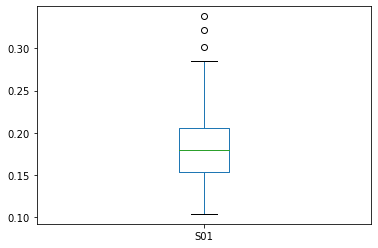

In [11]:
relSaccData.groupby('subj_id')['latency'].plot(kind='box')

In [12]:
relSaccData.groupby('subj_id')['latency'].describe()

count      mean       std       min       25%       50%       75%  \
subj_id                                                                      
S01       54.0  0.186036  0.049413  0.104215  0.153315  0.179255  0.206067   

             max  
subj_id           
S01      0.33792